# Imports

In [281]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants

importlib.reload(constants)
from constants import *

nest.ResetKernel()

# Functions

## Setup

In [282]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "tau_m": E_NEURON_TAU_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I

    nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def connect_pop_base(layer_e, layer_i):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """

    # Define a distance‐dependent connection rule
    distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, std=GAUSSIAN_STD)
    conndict = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution > DISTRIBUTION_THRESHOLD, distribution, 0),
        "mask": {"circular": {"radius": MASK_RADIUS}},
    }

    # Copy a generic synapse model
    nest.CopyModel("tsodyks_synapse", "synapse")

    # Define weights
    exc_weight = EXC_WEIGHT
    inh_weight = INH_WEIGHT

    # Make connections
    nest.Connect(layer_e, layer_i, conndict, syn_spec={"synapse_model": "synapse", "weight": exc_weight})
    nest.Connect(layer_i, layer_e, conndict, syn_spec={"synapse_model": "synapse", "weight": inh_weight})
    nest.Connect(layer_e, layer_e, conndict, syn_spec={"synapse_model": "synapse", "weight": exc_weight})
    nest.Connect(layer_i, layer_i, conndict, syn_spec={"synapse_model": "synapse", "weight": inh_weight})

    connections = nest.GetConnections(synapse_model="synapse")

def connect_pop_tsodyks(layer_e, layer_i):
    """
    Connects populations with distance-dependent synapse models (Tsodyks for short-range, static for long-range).
    """

    # Define connection rules
    distribution_short = nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.6)
    short_range_rule = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_short > 0.2, distribution_short, 0),
        "mask": {"circular": {"radius": 0.5}}
    }
    long_range_rule = {
        "rule": "fixed_total_number",
        "N": int(0.1 * len(layer_e) * len(layer_i))
    }

    # Define synapse parameters
    short_range_syn_params = {
        "U": 0.8,
        "tau_rec": 200.0,
        "tau_fac": 50.0,
        "weight": -1.0
    }
    long_range_syn_params = {
        "U": 0.3,
        "tau_rec": 50.0,
        "tau_fac": 100.0,
        "weight": 0.5
    }

    nest.CopyModel("tsodyks_synapse", "short_syn", short_range_syn_params)
    nest.CopyModel("tsodyks_synapse", "long_syn", long_range_syn_params)

    # Make connections with both synapse models
    nest.Connect(layer_e, layer_i, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_e, layer_i, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_i, layer_e, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_i, layer_e, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_i, layer_i, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_i, layer_i, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_e, layer_e, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_e, layer_e, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})

    num_short = len(nest.GetConnections(synapse_model="short_syn"))
    num_long = len(nest.GetConnections(synapse_model="long_syn"))
    print(f"Synapses with STP: {num_short}")
    print(f"Synapses without STP: {num_long}")

    connections_short = nest.GetConnections(synapse_model="short_syn")
    connections_long = nest.GetConnections(synapse_model="long_syn")
    
    return connections_short, connections_long

def create_thalamic_input(layer_e):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": THALAMIC_INPUT_FIRING_RATE})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": THALAMIC_INPUT_WEIGHT, "delay": THALAMIC_INPUT_DELAY}) 
    return thalamic_input

## Monitoring

In [283]:
def recording_devices(layer_e, layer_i, input):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    sr_i = nest.Create("spike_recorder")
    sr_input = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    nest.Connect(layer_i, sr_i)
    nest.Connect(input, sr_input)

    multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e)
    nest.Connect(multimeter_i, layer_i)

    return multimeter_e, multimeter_i, sr_e, sr_i, sr_input

def plot_spikes(sr_e, sr_i, sr_input):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    # poisson generator
    spike_events_input = nest.GetStatus(sr_input, "events")[0]
    senders_input = spike_events_input["senders"]
    times_input = spike_events_input["times"]

    dots_size = 3

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(times_e, senders_e, s=dots_size, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=dots_size, label="Inhibitory", color="blue")
    ax.scatter(times_input, senders_input, s=dots_size, label="Input", color="orange")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Simulation

In [284]:
nest.set_verbosity("M_ERROR") # nest shut up

nest.ResetKernel()

layer_e, layer_i = create_populations()
connect_pop_tsodyks(layer_e, layer_i)
input = create_thalamic_input(layer_e)

multimeter_e, multimeter_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)

# Run simulation (adjust simulation time as needed)
nest.Simulate(200)

Synapses with STP: 647
Synapses without STP: 148


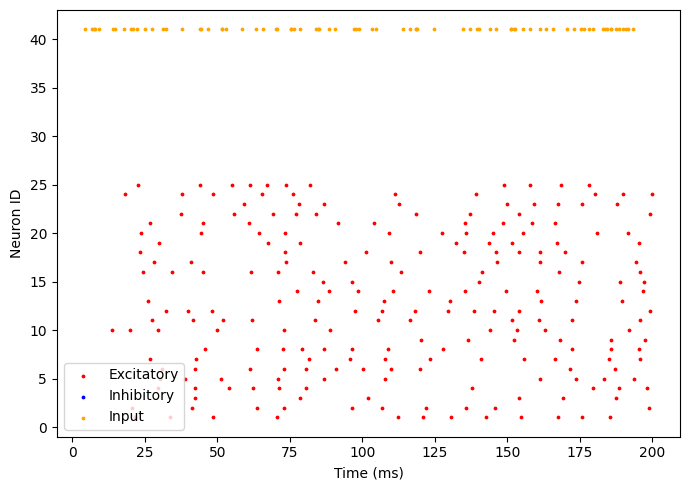

In [285]:
# Plot outputs
plot_spikes(sr_e, sr_i, sr_input)